In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a first attempt to read in track information and use it to predict the the full target histrograms.

It will read in the TracksToDKE__Ellipsoids_DDPlus model to predict the KDE, and then feed it into a SimpleCNN model to predict the target histograms.  Initially, it will use previously trained weights.


Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Tue Dec 29 11:46:29 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 450.36.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:18:00.0 Off |                  N/A |
| 29%   40C    P8    40W / 250W |    891MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:3B:00.0 Off |                  N/A |
| 29%   

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from model.efficiency import pv_locations, efficiency

##from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 100

# Name is the output file name


##  200719  mds
##folder = '20December_Tracks_to_KDE_TestTrainedModel'
##folder = '22December_testing_DDplus_loss_Bb_iter2_floatAll_100epochs_3em6'
folder = '29December_Tracks_to_Hists_Iteration_2B_100epochs_lr_1em7_2p5_kde2hists_allFloat'
name = folder

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = 'ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 16
# How fast to learn
learning_rate = 1e-7

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
##from model.collectdata_kde_Ellipsoids import collect_t2kde_data
from model.collectdata_t2hists import collect_t2hists_data
from model.collectdata_mdsA  import collect_truth

# From model/loss.py
##from loss import Loss
##from model.kde_loss_D import Loss
## from model.kde_loss_B import Loss  ## Tracks_to_KDE loss, not for target hists

##  "standard" ratios loss for hists training
from model.alt_loss_A import Loss  ## loss used to train RunModel_Demo_28November2020-SimpleCNNLayer_Ca-Restart_5


##from model.models_kde import TracksToKDE_Ellipsoids_DirtyDozen as Model
from model.models_kde import TracksToKDE_Ellipsoids_DDplus as t2kde_model
##from model.models_mds_G import SimpleCNN5Layer_Ca as kde2hists_model
from model.models_mds_28Dec20 import SimpleCNN5Layer_Ca as kde2hists_model  ## copy of models_mds_01June20 for debugging
from model.models_t2hists import TracksToHists_A as t2hists_model


##from model.training_kde import trainNet, select_gpu, Results
## training_t2hists_A.py increases "difference" for accepting found
## peaks as matched from 5 bins to 7.5 bins (compmared to original training.py)
from model.training_t2hists_A import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)
##device = "cpu"

1 available GPUs (initially using device 0):
  0 GeForce RTX 2080 Ti


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
train_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                             slice = slice(0,18000)
                           )



                            
# Validation dataset. You can slice to reduce the size.
## mds no separate validation set yet,
val_loader = collect_t2hists_data('dataAA/20K_POCA_kernel_evts_200926.h5',
                            batch_size=batch_size,
                            device=device,
                            slice = slice(18000,None)
                           )

PV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=True)
print('PV.n.shape =    ',  PV.n.shape)
print('PV.n[0].shape = ', *PV.n[0].shape)
print('PV.x[0] =       ', *PV.x[0])
print('PV.y[0] =       ', *PV.y[0])
print('PV.z[0] =       ', *PV.z[0])
print('PV.n[0] =       ', *PV.n[0])
print('PV.cat[0] =     ', *PV.cat[0])

SV = collect_truth('dataAA/20K_POCA_kernel_evts_200926.h5', pvs=False)
print('SV.n.shape =    ', SV.n.shape)
print('SV.n[0].shape = ', *SV.n[0].shape)
print('SV.x[0] =       ', *SV.x[0])
print('SV.y[0] =       ', *SV.y[0])
print('SV.z[0] =       ', *SV.z[0])
print('SV.n[0] =       ', *SV.n[0])
print('SV.cat[0] =     ', *SV.cat[0])


Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 21
 iEvt, nTrks =  2 20
 iEvt, nTrks =  3 198
 iEvt, nTrks =  4 233
 iEvt, nTrks =  5 85
 iEvt, nTrks =  6 223
 iEvt, nTrks =  7 425
 iEvt, nTrks =  8 252
 iEvt, nTrks =  9 169
len(X) =  20000
len(Xlist) =  1
Loaded dataAA/20K_POCA_kernel_evts_200926.h5 in 27.58 s
outer loop X.shape =  (20000, 9, 600)
Constructing 18000 event dataset took 0.2443 s
x_t.shape =  torch.Size([18000, 9, 600])
x_t.shape[0] =  18000
x_t.shape[1] =  9
x_t.shape =  torch.Size([18000, 9, 600])
Loading data...
pocaMx.shape =  (20000,)
nEvts =  20000
len(pocaMx[0]) =  211
len(pocaMx[1]) =  21
len(pocaMx[2]) =  20
len(pocaMx[3]) =  198
len(pocaMx[4]) =  233
have entered six_ellipsoid_parameters
  
 
  nEvts =  20000
 iEvt, nTrks =  0 211
 iEvt, nTrks =  1 

# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
nOut1 = 50
nOut2 = 50
nOut3 = 50
nOut4 = 50
nOut5 = 50
nOut6 = 50
nOut7 = 50
nOut8 = 50
nOut9 = 50
nOut10 = 50
nOut11 = 50
latentChannels = 4
model_t2kde = t2kde_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)
model_kde2hists = kde2hists_model()
model_t2hists = t2hists_model(nOut1,nOut2,nOut3,nOut4,nOut5,nOut6,nOut7,nOut8,nOut9,nOut10,nOut11,latentChannels)

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model_t2hists.children():
  print('ct, child = ',ct, "  ", child)
  if (ct < 0) :
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1

loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model_t2hists.parameters(), lr=learning_rate)

ct, child =  0    Linear(in_features=9, out_features=50, bias=True)
ct, child =  1    Linear(in_features=50, out_features=50, bias=True)
ct, child =  2    Linear(in_features=50, out_features=50, bias=True)
ct, child =  3    Linear(in_features=50, out_features=50, bias=True)
ct, child =  4    Linear(in_features=50, out_features=50, bias=True)
ct, child =  5    Linear(in_features=50, out_features=50, bias=True)
ct, child =  6    Linear(in_features=50, out_features=50, bias=True)
ct, child =  7    Linear(in_features=50, out_features=50, bias=True)
ct, child =  8    Linear(in_features=50, out_features=50, bias=True)
ct, child =  9    Linear(in_features=50, out_features=50, bias=True)
ct, child =  10    Linear(in_features=50, out_features=50, bias=True)
ct, child =  11    Linear(in_features=50, out_features=16000, bias=True)
ct, child =  12    Conv1d(4, 25, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  13    Conv1d(25, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child 

Let's move the model's weight matricies to the GPU:

In [14]:
## want to look at all three dictionaries to start:
##  t2kde
##  kde2hists
##  t2hists
## the plan is to (initially) copy weights from separate dictionaries into th t2hists dictionary

##   ML -> /share/lazy/sokoloff/ML
'''
model_t2kde_dict = model_t2kde.state_dict()
## mds 190725 for debugging
print("for model_t2kde_dict")
index = 0
for k,v in model_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_kde2hists_dict = model_kde2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#
model_t2hists_dict = model_t2hists.state_dict()
## mds 190725 for debugging
print("for model_hists_2kde_dict")
index = 0
for k,v in model_t2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
#

##  build the "updated_dict" to become the t2hists_dictionary from the
##  t2kde and kde2hist dictionaries
update_dict = model_t2hists_dict
##print("updated_dict = ",updated_dict)
## when starting "ab initio", reduce biases as the bias gets summed for each track
## contributing to the predicted KDE
'''


'''
updated_dict["layer1.bias"] = 0.005*model_dict["layer1.bias"]
updated_dict["layer2.bias"] = 0.005*model_dict["layer2.bias"]
updated_dict["layer3.bias"] = 0.005*model_dict["layer3.bias"]
updated_dict["layer4.bias"] = 0.005*model_dict["layer4.bias"]
updated_dict["layer5.bias"] = 0.005*model_dict["layer5.bias"]
updated_dict["layer6.bias"] = 0.005*model_dict["layer6.bias"]
updated_dict["layer7.bias"] = 0.005*model_dict["layer7.bias"]
updated_dict["layer8.bias"] = 0.005*model_dict["layer8.bias"]
updated_dict["layer9.bias"] = 0.005*model_dict["layer9.bias"]
updated_dict["layer10.bias"] = 0.005*model_dict["layer10.bias"]
updated_dict["layer11.bias"] = 0.005*model_dict["layer11.bias"]
'''

'''
##model_t2hists.load_state_dict(updated_dict,strict=False)

##model__t2hists_dict = model_t2hists.state_dict()

## let's get the tracks-to-kde model here
t2kde_folder = '25December__DDplus_loss_Ba_iter5_floatAll_800epochs_5em6'  ## really iter6, really Dec. 27
t2kde_folder = '25December__DDplus_loss_Ba_iter7_floatAll_800epochs_4em6'
t2kde_name = t2kde_folder
suffix = 'final'
t2kde_dict_name = 'ML/' + t2kde_folder + '/' + t2kde_name + '_'+ suffix + '.pyt'
print('t2kde_dict_name = ',t2kde_dict_name)
pretrained_t2kde_dict = torch.load(t2kde_dict_name)

print(" \n","  for t2kde_pretrained_dict")
index = 0
for k,v in pretrained_t2kde_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
    
## let's get the hists-to-kde model here   
kde2hists_folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
kde2hists_name = kde2hists_folder
suffix = 'final'
kde2hists_dict_name = 'ML/' + kde2hists_folder + '/' + kde2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_kde2hists_dict = torch.load(kde2hists_dict_name)

print(" \n","  for kde2hists_pretrained_dict")
index = 0
for k,v in pretrained_kde2hists_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
 


##print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_t2kde_dict.items() if k in model_t2hists_dict}
## mds dec28 print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_t2hists_dict.update(pretrained_dict) 

update_dict["hist_conv1.weight"] = pretrained_kde2hists_dict["conv1.weight"]
update_dict["hist_conv1.bias"]   = pretrained_kde2hists_dict["conv1.bias"]
update_dict["hist_conv2.weight"] = pretrained_kde2hists_dict["conv2.weight"]
update_dict["hist_conv2.bias"]   = pretrained_kde2hists_dict["conv2.bias"]
update_dict["hist_conv3.weight"] = pretrained_kde2hists_dict["conv3.weight"]
update_dict["hist_conv3.bias"]   = pretrained_kde2hists_dict["conv3.bias"]
update_dict["hist_conv4.weight"] = pretrained_kde2hists_dict["conv4.weight"]
update_dict["hist_conv4.bias"]   = pretrained_kde2hists_dict["conv4.bias"]
update_dict["hist_conv5.weight"] = pretrained_kde2hists_dict["conv5.weight"]
update_dict["hist_conv5.bias"]   = pretrained_kde2hists_dict["conv5.bias"]
update_dict["hist_fc1.weight"]   = pretrained_kde2hists_dict["fc1.weight"]
update_dict["hist_fc1.bias"]     = pretrained_kde2hists_dict["fc1.bias"]

##model_t2hists.update(update_dict,strict=False)
model_t2hists.load_state_dict(update_dict,strict=False)
model_t2hists_dict = model_t2hists.state_dict()
'''

##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

t2hists_folder = '28December_Tracks_to_Hists_FirstTraining_700epochs_lr_1em7_2p5_kde2hists_frozen'
t2hists_name = t2hists_folder
suffix = 'final'
t2hists_dict_name = 'ML/' + t2hists_folder + '/' +t2hists_name + '_'+ suffix + '.pyt'
## mds dec28 print('kde2hists_dict_name = ',kde2hists_dict_name)
pretrained_t2hists_dict = torch.load(t2hists_dict_name) 

model_t2hists.load_state_dict(pretrained_t2hists_dict,strict=False)

##  print('model_t2hists_dict =    ', model_t2hists_dict)


<All keys matched successfully>

In [15]:
##print('validation.dataset.tensors = ',validation.dataset.tensors)
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 4
plt.rcParams["figure.figsize"] = fig_size

In [16]:
model = model_t2hists.to(device)

<IPython.core.display.Javascript object>


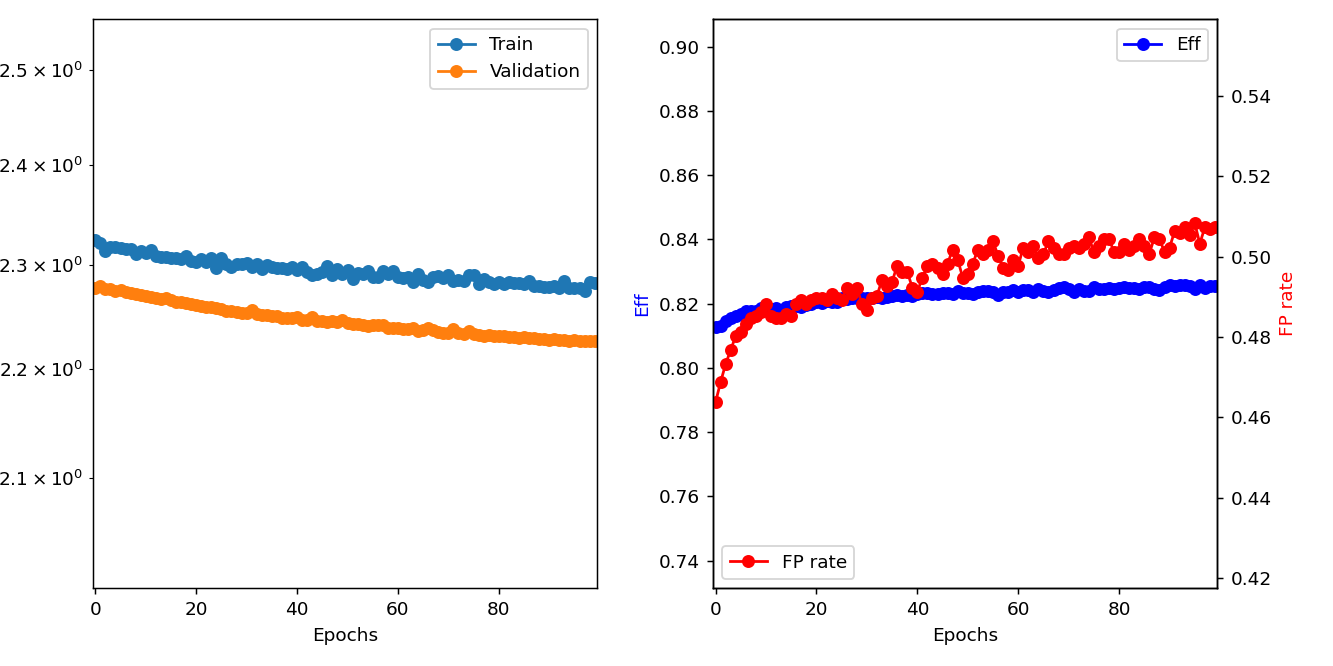

In [17]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [18]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
##    print("xs = ",xs)
    
    # Update the plot above
##    print("results.index = ",results.index,"  results.cost", results.cost)
##    print("results.index = ",results.index,"  results.val", results.val)
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1125, val = 125


Epoch 0: train=2.3242, val=2.2777, took 43.171 s
  Validation Found 8792 of 10819, added 928 (eff 81.26%) (0.464 FP/event)


Epoch 1: train=2.32204, val=2.2793, took 43.68 s
  Validation Found 8795 of 10819, added 938 (eff 81.29%) (0.469 FP/event)


Epoch 2: train=2.31384, val=2.27606, took 43.678 s
  Validation Found 8812 of 10819, added 947 (eff 81.45%) (0.473 FP/event)


Epoch 3: train=2.31801, val=2.27639, took 43.612 s
  Validation Found 8823 of 10819, added 954 (eff 81.55%) (0.477 FP/event)


Epoch 4: train=2.31795, val=2.2745, took 43.676 s
  Validation Found 8831 of 10819, added 961 (eff 81.62%) (0.48 FP/event)


Epoch 5: train=2.31695, val=2.27546, took 43.739 s
  Validation Found 8838 of 10819, added 963 (eff 81.69%) (0.481 FP/event)


Epoch 6: train=2.3153, val=2.27406, took 43.833 s
  Validation Found 8847 of 10819, added 967 (eff 81.77%) (0.483 FP/event)


Epoch 7: train=2.31604, val=2.27279, took 44.042 s
  Validation Found 8847 of 10819, added 970 (eff 81.77%) (0.485 FP/event)


Epoch 8: train=2.31038, val=2.27131, took 44.082 s
  Validation Found 8847 of 10819, added 971 (eff 81.77%) (0.485 FP/event)


Epoch 9: train=2.31388, val=2.27031, took 43.945 s
  Validation Found 8858 of 10819, added 973 (eff 81.87%) (0.486 FP/event)


Epoch 10: train=2.31185, val=2.26951, took 43.853 s
  Validation Found 8856 of 10819, added 977 (eff 81.86%) (0.488 FP/event)


Epoch 11: train=2.31459, val=2.26892, took 43.989 s
  Validation Found 8853 of 10819, added 971 (eff 81.83%) (0.485 FP/event)


Epoch 12: train=2.30864, val=2.26738, took 43.9 s
  Validation Found 8856 of 10819, added 970 (eff 81.86%) (0.485 FP/event)


Epoch 13: train=2.30788, val=2.26716, took 43.91 s
  Validation Found 8851 of 10819, added 970 (eff 81.81%) (0.485 FP/event)


Epoch 14: train=2.30754, val=2.26769, took 43.904 s
  Validation Found 8862 of 10819, added 972 (eff 81.91%) (0.486 FP/event)


Epoch 15: train=2.30662, val=2.26544, took 43.85 s
  Validation Found 8865 of 10819, added 971 (eff 81.94%) (0.485 FP/event)


Epoch 16: train=2.3068, val=2.26429, took 43.884 s
  Validation Found 8863 of 10819, added 977 (eff 81.92%) (0.488 FP/event)


Epoch 17: train=2.30619, val=2.26389, took 43.864 s
  Validation Found 8861 of 10819, added 979 (eff 81.90%) (0.489 FP/event)


Epoch 18: train=2.30927, val=2.2628, took 43.878 s
  Validation Found 8866 of 10819, added 977 (eff 81.95%) (0.488 FP/event)


Epoch 19: train=2.30371, val=2.2622, took 44.25 s
  Validation Found 8871 of 10819, added 979 (eff 81.99%) (0.489 FP/event)


Epoch 20: train=2.30272, val=2.26095, took 43.62 s
  Validation Found 8877 of 10819, added 980 (eff 82.05%) (0.49 FP/event)


Epoch 21: train=2.30575, val=2.26043, took 43.9 s
  Validation Found 8873 of 10819, added 980 (eff 82.01%) (0.49 FP/event)


Epoch 22: train=2.30297, val=2.25952, took 43.613 s
  Validation Found 8880 of 10819, added 979 (eff 82.08%) (0.489 FP/event)


Epoch 23: train=2.30636, val=2.259, took 43.928 s
  Validation Found 8877 of 10819, added 982 (eff 82.05%) (0.491 FP/event)


Epoch 24: train=2.2974, val=2.25782, took 43.635 s
  Validation Found 8877 of 10819, added 980 (eff 82.05%) (0.49 FP/event)


Epoch 25: train=2.30685, val=2.25747, took 43.878 s
  Validation Found 8892 of 10819, added 979 (eff 82.19%) (0.489 FP/event)


Epoch 26: train=2.30135, val=2.25566, took 44.0 s
  Validation Found 8889 of 10819, added 985 (eff 82.16%) (0.492 FP/event)


Epoch 27: train=2.29824, val=2.25507, took 43.838 s
  Validation Found 8890 of 10819, added 982 (eff 82.17%) (0.491 FP/event)


Epoch 28: train=2.30083, val=2.25432, took 43.813 s
  Validation Found 8892 of 10819, added 985 (eff 82.19%) (0.492 FP/event)


Epoch 29: train=2.30066, val=2.2538, took 43.823 s
  Validation Found 8890 of 10819, added 977 (eff 82.17%) (0.488 FP/event)


Epoch 30: train=2.30218, val=2.25343, took 43.691 s
  Validation Found 8892 of 10819, added 974 (eff 82.19%) (0.487 FP/event)


Epoch 31: train=2.29799, val=2.25583, took 43.697 s
  Validation Found 8891 of 10819, added 980 (eff 82.18%) (0.49 FP/event)


Epoch 32: train=2.30083, val=2.2521, took 43.758 s
  Validation Found 8894 of 10819, added 981 (eff 82.21%) (0.49 FP/event)


Epoch 33: train=2.2959, val=2.25126, took 43.908 s
  Validation Found 8892 of 10819, added 989 (eff 82.19%) (0.494 FP/event)


Epoch 34: train=2.29949, val=2.25104, took 43.733 s
  Validation Found 8894 of 10819, added 986 (eff 82.21%) (0.493 FP/event)


Epoch 35: train=2.29837, val=2.25022, took 43.792 s
  Validation Found 8896 of 10819, added 988 (eff 82.23%) (0.494 FP/event)


Epoch 36: train=2.2966, val=2.25023, took 43.615 s
  Validation Found 8901 of 10819, added 996 (eff 82.27%) (0.498 FP/event)


Epoch 37: train=2.29662, val=2.24898, took 43.837 s
  Validation Found 8899 of 10819, added 993 (eff 82.25%) (0.496 FP/event)


Epoch 38: train=2.29629, val=2.2486, took 43.694 s
  Validation Found 8900 of 10819, added 993 (eff 82.26%) (0.496 FP/event)


Epoch 39: train=2.29753, val=2.24841, took 43.739 s
  Validation Found 8899 of 10819, added 985 (eff 82.25%) (0.492 FP/event)


Epoch 40: train=2.29533, val=2.24912, took 43.961 s
  Validation Found 8905 of 10819, added 983 (eff 82.31%) (0.491 FP/event)


Epoch 41: train=2.29763, val=2.24695, took 43.829 s
  Validation Found 8906 of 10819, added 990 (eff 82.32%) (0.495 FP/event)


Epoch 42: train=2.2933, val=2.2467, took 43.624 s
  Validation Found 8906 of 10819, added 996 (eff 82.32%) (0.498 FP/event)


Epoch 43: train=2.29046, val=2.24969, took 43.988 s
  Validation Found 8904 of 10819, added 997 (eff 82.30%) (0.498 FP/event)


Epoch 44: train=2.29145, val=2.2455, took 44.213 s
  Validation Found 8905 of 10819, added 995 (eff 82.31%) (0.497 FP/event)


Epoch 45: train=2.29302, val=2.24569, took 43.692 s
  Validation Found 8906 of 10819, added 992 (eff 82.32%) (0.496 FP/event)


Epoch 46: train=2.29851, val=2.24456, took 43.728 s
  Validation Found 8908 of 10819, added 997 (eff 82.34%) (0.498 FP/event)


Epoch 47: train=2.29007, val=2.24608, took 43.867 s
  Validation Found 8905 of 10819, added 1004 (eff 82.31%) (0.502 FP/event)


Epoch 48: train=2.29623, val=2.24442, took 43.662 s
  Validation Found 8914 of 10819, added 999 (eff 82.39%) (0.499 FP/event)


Epoch 49: train=2.29144, val=2.24617, took 43.607 s
  Validation Found 8909 of 10819, added 990 (eff 82.35%) (0.495 FP/event)


Epoch 50: train=2.29515, val=2.24329, took 43.842 s
  Validation Found 8908 of 10819, added 992 (eff 82.34%) (0.496 FP/event)


Epoch 51: train=2.28669, val=2.24313, took 44.12 s
  Validation Found 8905 of 10819, added 997 (eff 82.31%) (0.498 FP/event)


Epoch 52: train=2.29179, val=2.24238, took 43.803 s
  Validation Found 8910 of 10819, added 1004 (eff 82.36%) (0.502 FP/event)


Epoch 53: train=2.29152, val=2.24186, took 43.923 s
  Validation Found 8913 of 10819, added 1002 (eff 82.38%) (0.501 FP/event)


Epoch 54: train=2.29396, val=2.24115, took 43.621 s
  Validation Found 8914 of 10819, added 1004 (eff 82.39%) (0.502 FP/event)


Epoch 55: train=2.28823, val=2.24141, took 43.966 s
  Validation Found 8911 of 10819, added 1008 (eff 82.36%) (0.504 FP/event)


Epoch 56: train=2.28825, val=2.24157, took 44.042 s
  Validation Found 8900 of 10819, added 1001 (eff 82.26%) (0.5 FP/event)


Epoch 57: train=2.29388, val=2.24139, took 43.653 s
  Validation Found 8910 of 10819, added 995 (eff 82.36%) (0.497 FP/event)


Epoch 58: train=2.29135, val=2.23938, took 43.752 s
  Validation Found 8912 of 10819, added 994 (eff 82.37%) (0.497 FP/event)


Epoch 59: train=2.2943, val=2.23879, took 43.588 s
  Validation Found 8919 of 10819, added 999 (eff 82.44%) (0.499 FP/event)


Epoch 60: train=2.28861, val=2.23867, took 44.154 s
  Validation Found 8911 of 10819, added 996 (eff 82.36%) (0.498 FP/event)


Epoch 61: train=2.28698, val=2.23753, took 43.546 s
  Validation Found 8917 of 10819, added 1005 (eff 82.42%) (0.502 FP/event)


Epoch 62: train=2.28841, val=2.23767, took 43.888 s
  Validation Found 8918 of 10819, added 1003 (eff 82.43%) (0.501 FP/event)


Epoch 63: train=2.28351, val=2.23902, took 43.735 s
  Validation Found 8910 of 10819, added 1006 (eff 82.36%) (0.503 FP/event)


Epoch 64: train=2.2912, val=2.23652, took 43.76 s
  Validation Found 8921 of 10819, added 1000 (eff 82.46%) (0.5 FP/event)


Epoch 65: train=2.28504, val=2.23671, took 43.826 s
  Validation Found 8916 of 10819, added 1002 (eff 82.41%) (0.501 FP/event)


Epoch 66: train=2.28351, val=2.23887, took 43.815 s
  Validation Found 8911 of 10819, added 1008 (eff 82.36%) (0.504 FP/event)


Epoch 67: train=2.28816, val=2.23737, took 43.96 s
  Validation Found 8919 of 10819, added 1005 (eff 82.44%) (0.502 FP/event)


Epoch 68: train=2.28899, val=2.23515, took 43.68 s
  Validation Found 8926 of 10819, added 1002 (eff 82.50%) (0.501 FP/event)


Epoch 69: train=2.28746, val=2.2345, took 43.721 s
  Validation Found 8927 of 10819, added 1002 (eff 82.51%) (0.501 FP/event)


Epoch 70: train=2.29057, val=2.23417, took 43.783 s
  Validation Found 8922 of 10819, added 1005 (eff 82.47%) (0.502 FP/event)


Epoch 71: train=2.28431, val=2.23756, took 43.845 s
  Validation Found 8911 of 10819, added 1006 (eff 82.36%) (0.503 FP/event)


Epoch 72: train=2.28575, val=2.23391, took 43.705 s
  Validation Found 8920 of 10819, added 1005 (eff 82.45%) (0.502 FP/event)


Epoch 73: train=2.28467, val=2.23345, took 43.989 s
  Validation Found 8916 of 10819, added 1007 (eff 82.41%) (0.503 FP/event)


Epoch 74: train=2.28975, val=2.23633, took 43.76 s
  Validation Found 8913 of 10819, added 1010 (eff 82.38%) (0.505 FP/event)


Epoch 75: train=2.29019, val=2.23303, took 43.896 s
  Validation Found 8928 of 10819, added 1003 (eff 82.52%) (0.501 FP/event)


Epoch 76: train=2.2817, val=2.23255, took 43.811 s
  Validation Found 8920 of 10819, added 1006 (eff 82.45%) (0.503 FP/event)


Epoch 77: train=2.28648, val=2.23175, took 43.804 s
  Validation Found 8920 of 10819, added 1009 (eff 82.45%) (0.504 FP/event)


Epoch 78: train=2.28335, val=2.23189, took 43.752 s
  Validation Found 8925 of 10819, added 1009 (eff 82.49%) (0.504 FP/event)


Epoch 79: train=2.28096, val=2.23143, took 43.846 s
  Validation Found 8920 of 10819, added 1003 (eff 82.45%) (0.501 FP/event)


Epoch 80: train=2.28326, val=2.23171, took 43.794 s
  Validation Found 8923 of 10819, added 1003 (eff 82.48%) (0.501 FP/event)


Epoch 81: train=2.2811, val=2.23147, took 43.69 s
  Validation Found 8928 of 10819, added 1007 (eff 82.52%) (0.503 FP/event)


Epoch 82: train=2.28372, val=2.23046, took 43.553 s
  Validation Found 8924 of 10819, added 1004 (eff 82.48%) (0.502 FP/event)


Epoch 83: train=2.28219, val=2.23, took 43.764 s
  Validation Found 8924 of 10819, added 1006 (eff 82.48%) (0.503 FP/event)


Epoch 84: train=2.28251, val=2.22972, took 43.811 s
  Validation Found 8921 of 10819, added 1009 (eff 82.46%) (0.504 FP/event)


Epoch 85: train=2.28097, val=2.23043, took 43.827 s
  Validation Found 8927 of 10819, added 1006 (eff 82.51%) (0.503 FP/event)


Epoch 86: train=2.28391, val=2.22983, took 43.717 s
  Validation Found 8927 of 10819, added 1002 (eff 82.51%) (0.501 FP/event)


Epoch 87: train=2.2791, val=2.22936, took 43.589 s
  Validation Found 8920 of 10819, added 1010 (eff 82.45%) (0.505 FP/event)


Epoch 88: train=2.27991, val=2.22875, took 43.876 s
  Validation Found 8918 of 10819, added 1009 (eff 82.43%) (0.504 FP/event)


Epoch 89: train=2.27861, val=2.22862, took 43.859 s
  Validation Found 8929 of 10819, added 1003 (eff 82.53%) (0.501 FP/event)


Epoch 90: train=2.27852, val=2.22781, took 43.737 s
  Validation Found 8933 of 10819, added 1005 (eff 82.57%) (0.502 FP/event)


Epoch 91: train=2.27957, val=2.22846, took 43.985 s
  Validation Found 8932 of 10819, added 1013 (eff 82.56%) (0.506 FP/event)


Epoch 92: train=2.27745, val=2.22771, took 44.39 s
  Validation Found 8933 of 10819, added 1012 (eff 82.57%) (0.506 FP/event)


Epoch 93: train=2.28425, val=2.22765, took 43.808 s
  Validation Found 8935 of 10819, added 1015 (eff 82.59%) (0.507 FP/event)


Epoch 94: train=2.27754, val=2.22657, took 43.633 s
  Validation Found 8931 of 10819, added 1011 (eff 82.55%) (0.505 FP/event)


Epoch 95: train=2.27714, val=2.22744, took 43.529 s
  Validation Found 8922 of 10819, added 1017 (eff 82.47%) (0.508 FP/event)


Epoch 96: train=2.27719, val=2.22634, took 43.833 s
  Validation Found 8936 of 10819, added 1007 (eff 82.60%) (0.503 FP/event)


Epoch 97: train=2.27486, val=2.22613, took 43.634 s
  Validation Found 8925 of 10819, added 1015 (eff 82.49%) (0.507 FP/event)


Epoch 98: train=2.28377, val=2.22651, took 43.928 s
  Validation Found 8930 of 10819, added 1014 (eff 82.54%) (0.507 FP/event)


Epoch 99: train=2.28219, val=2.22648, took 44.458 s
  Validation Found 8931 of 10819, added 1015 (eff 82.55%) (0.507 FP/event)



In [19]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

In [20]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/apps/miniconda3/envs/june2020-gpu/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


<IPython.core.display.Javascript object>


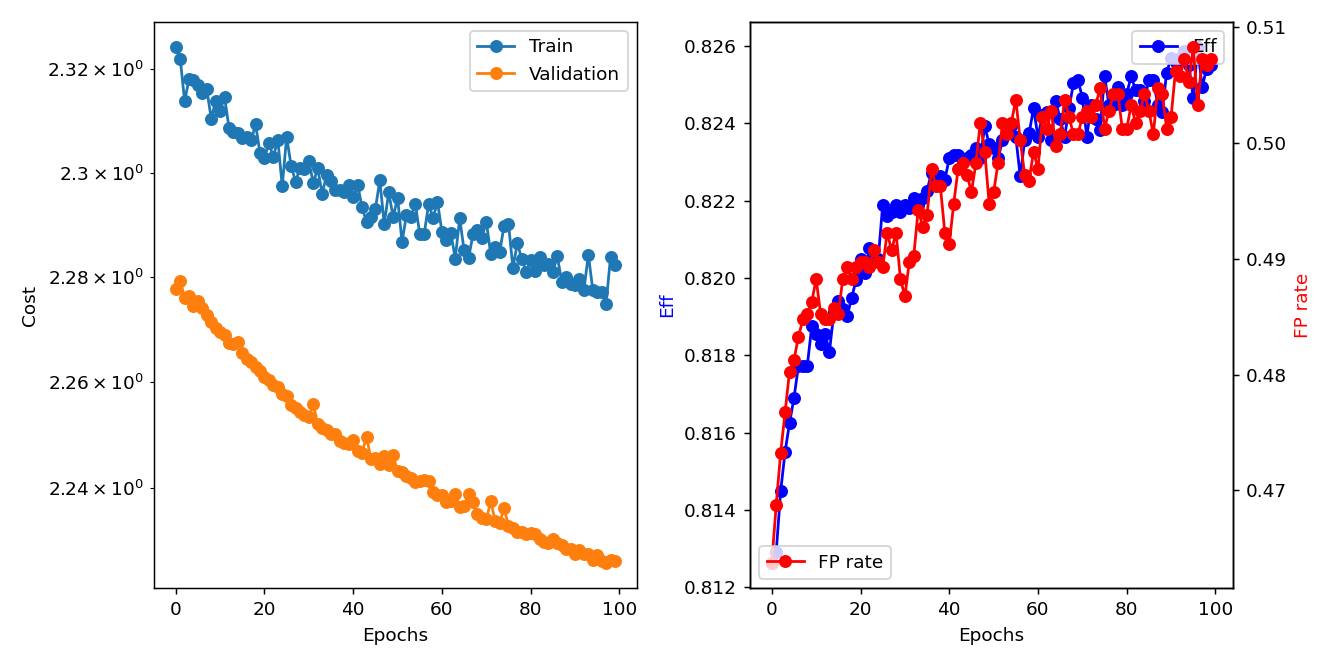

In [21]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

Go ahead and save the final model (even though it was also saved above):

Save the output results:

In [ ]:
##quit()

